# S3: All cells characterization

In [10]:
from notebook_utils import *

# print modules and versions            
imports()

pandas: 1.0.3
numpy: 1.18.2
scanpy.api: 1.4.4.post1
anndata: 0.6.22rc1
plotnine: 0.6.0
scipy: 1.4.1
more_itertools: 8.2.0
tqdm: 4.45.0
sklearn: 0.22.2.post1
lifelines: 0.24.3
matplotlib: 3.0.3


In [11]:
# import adata and associated files
wkdir = '/home/ubuntu/data/DL20181011_melanocyte_test_data/local_data'

for file in ['raw_adata', 
             'full_adata',
             'DE_df',
            ]:
    var = pickle.load((open(f'{wkdir}/{file}.p', 'rb')))
    exec(f'{file} = var')
    del var
    
# for parallel processes
usable_cores = multiprocessing.cpu_count()-1

# update subtypes
full_adata.obs['subtypes'] = ['follicular' if x in ['light_foll_mel', 'dark_foll_mel', 'cyc_foll_mel'] \
                         else y \
                         for x,y in zip(full_adata.obs.class_1, full_adata.obs.subtypes)]

# label order
dev_stage_order = ['fet','neo','adt']
subtypes_order = ['cutaneous','acral','foreskin','follicular']
acral_subtype_order = ['acral','not_acral']
foreskin_subtype_order = ['foreskin','not_foreskin']
follicular_subtype_order = ['follicular','not_follicular']
dev_subtype_order = ['fet_acral','fet_cutaneous','fet_follicular','neo_foreskin','adt_acral','adt_cutaneous']

# create class_2 for site granularity
full_adata.obs['class_2'] = [x if x not in ['mel'] \
                             else f'{y}_mel'
                             for x,y in zip(full_adata.obs['class_1'], full_adata.obs['subtypes'])]

# create class_3 for site+dev_stage granularity
full_adata.obs['class_3'] = [x if not x.endswith('_mel') or x.startswith('cyc_') \
                             else f'{y}_{x}'
                             for x,y in zip(full_adata.obs['class_2'], full_adata.obs['dev_stage'])]

# update class_1 to pool by cell type
full_adata.obs['class_1'] = [x if not x.endswith('_mel') \
                             else 'mel' if not x.startswith('cyc_') \
                             else 'cyc_mel' \
                             for x in full_adata.obs['class_1']]
    
DE_df['class_1'] = (DE_df['class_1']
                      .astype(str)
                      .astype(CategoricalDtype(type_order_1, ordered=True))
                     )
DE_df = DE_df.dropna()


## all cells UMAP

In [12]:
sc.pp.neighbors(full_adata, n_pcs=20, n_neighbors=100, random_state=1) # new
sc.tl.umap(full_adata, min_dist = 0.5, random_state=1, init_pos='random')

/home/ubuntu/py_36_env/lib/python3.6/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../py_36_env/lib/python3.6/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


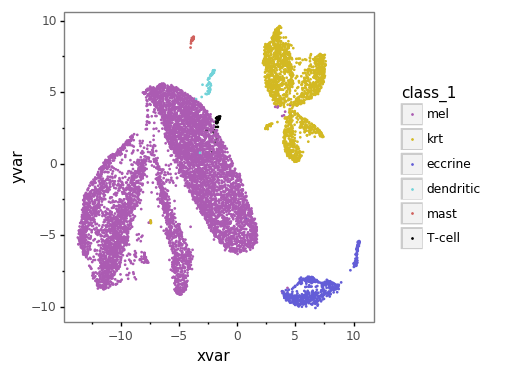

<ggplot: (8772799706849)>


In [13]:
plot_dict = {'class_1':type_order_1,
#              'class_2':type_order_2,
#              'class_3':type_order_3
            }

for key,value in plot_dict.items():

    class_ref = key
    type_order_ref = value

    input_adata = full_adata[[not x.startswith('cyc_') for x in full_adata.obs[class_ref]]]
    umap_df = pd.DataFrame(input_adata.obsm['X_umap'], columns = ['xvar','yvar'])
    umap_df[class_ref] = input_adata.obs[class_ref].values
    umap_df[class_ref] = (umap_df[class_ref]
                          .astype(str)
                          .astype(CategoricalDtype([x for x in type_order_ref \
                                                    if not x.startswith('cyc_') and \
                                                    x in set(umap_df[class_ref])
                                                   ], ordered=True))
                         )

    plotnine.options.figure_size = (4,4)
    plot = (ggplot(umap_df)
            + theme_bw()
            + theme(aspect_ratio = 1,
                    panel_grid_major = element_blank(), 
                    panel_grid_minor = element_blank()
                   )
            + geom_point(aes('xvar','yvar',color=class_ref), size = 0.1)
            + scale_color_manual(values = {'mel':'#ab5bb2',
                                           'krt':'#d3b922',
                                           'eccrine':'#635dd7',
                                           'dendritic':'#71d3d9',
                                           'mast':'#d0615d',
                                           'T-cell':'#000000',
                                          })
           )
    print(plot)


## all cells heatmap

computing...


/home/ubuntu/py_36_env/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/py_36_env/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


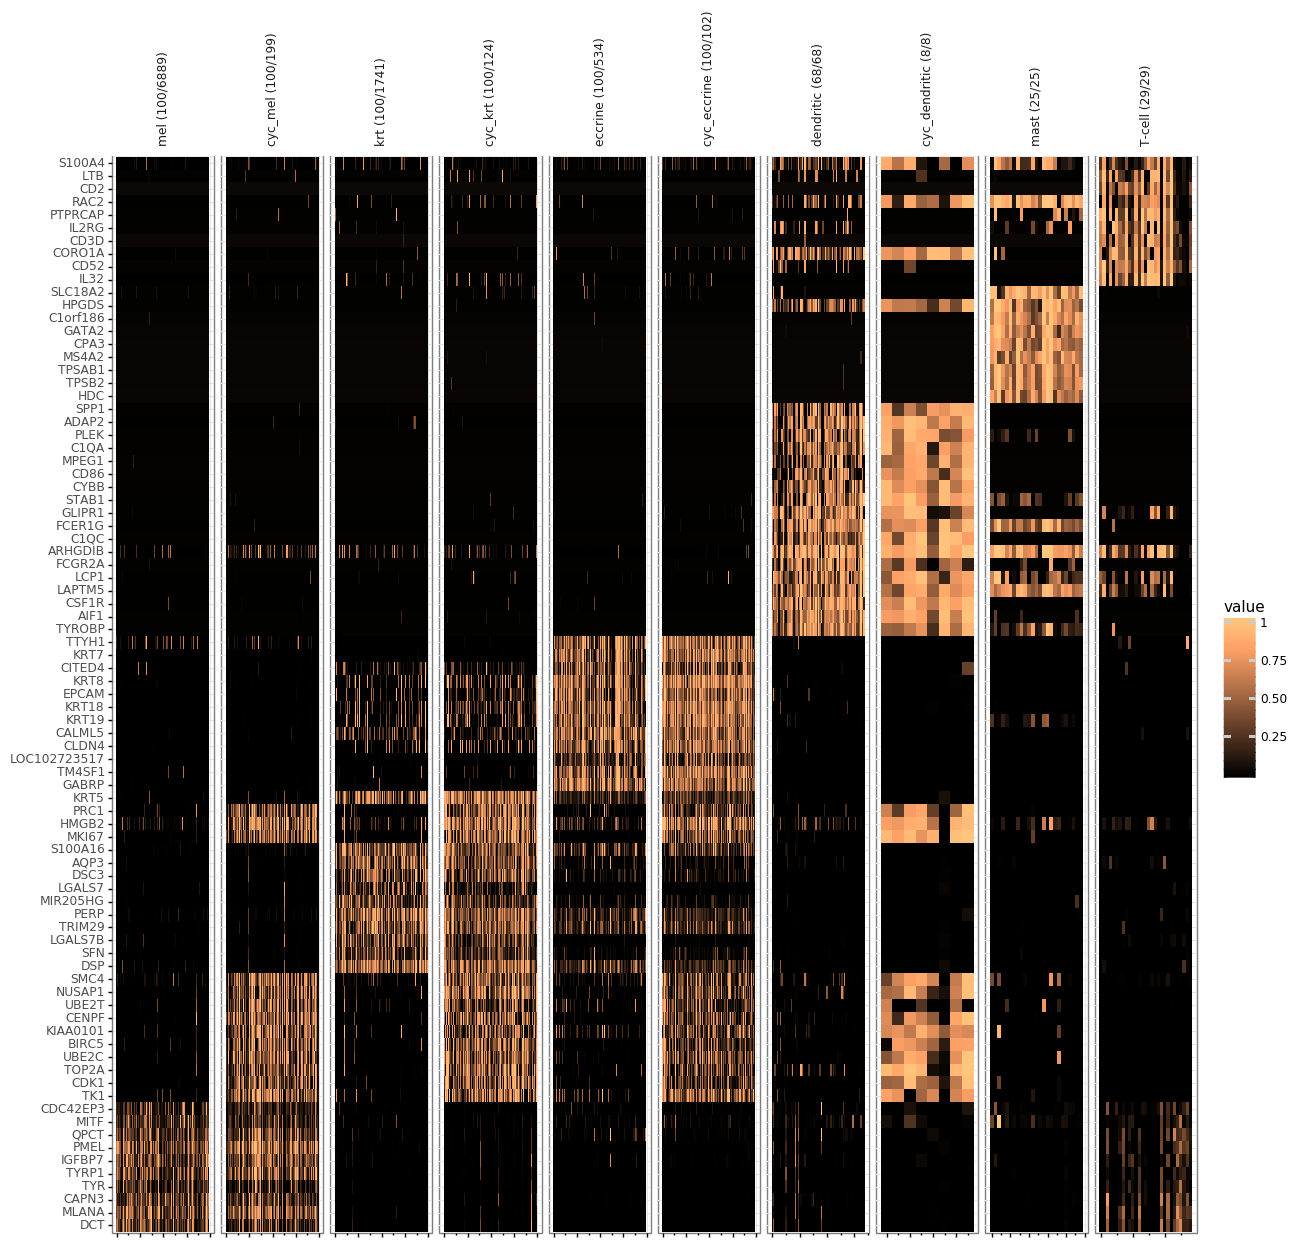

<ggplot: (-9223363264055121085)>


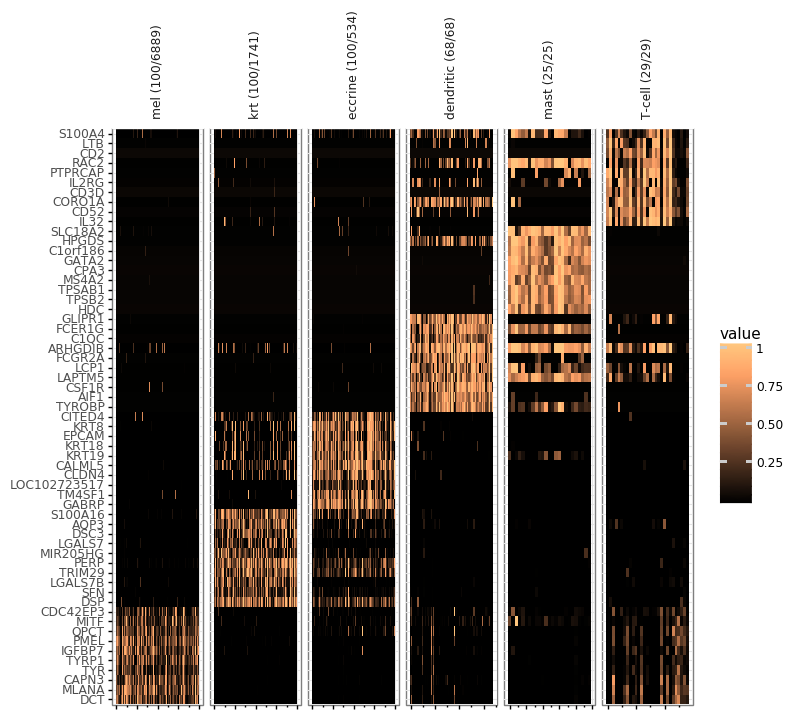

<ggplot: (-9223363264056120660)>


In [14]:
print('computing...')
input_adata = full_adata
n_cells = 100

# extract cell types and genes order
type_order = DE_df.class_1.cat.categories.tolist()
gene_order = []
for x in type_order:
    df_slice = DE_df[DE_df.class_1 == x]
    df_slice = df_slice[~df_slice.gene.duplicated(keep='first')]
    gene_order = gene_order + [x for x in df_slice.gene if x not in gene_order]


cat, exp_df = prepare_dataframe(input_adata,
                 var_names = input_adata.var_names.tolist(),
                 groupby = 'cell')

# exp_df = exp_df.apply(lambda x: min_max_scaler(x.values))
exp_df = exp_df.rank(pct = True, method='dense')
exp_df = exp_df.loc[:,gene_order]
exp_df['class_1'] = input_adata.obs.class_1.tolist()

compiled_rows = pd.DataFrame()
type_order_revised = []
for x in type_order:
    df_slice = exp_df[exp_df.class_1 == x]
    df_nrow = len(df_slice)
    if df_nrow >= n_cells:
        df_sample = df_slice.sample(n_cells)
        num_cell = n_cells
    else:
        df_sample = df_slice
        num_cell = df_nrow
    idx_list = [x for x in range(len(df_sample))]
    random.shuffle(idx_list)
    df_sample['idx'] = idx_list
    df_sample['class_1'] = f'{x} ({num_cell}/{df_nrow})'
    type_order_revised = type_order_revised + [f'{x} ({num_cell}/{df_nrow})']
    compiled_rows = compiled_rows.append(df_sample)
    
compiled_rows_melt = pd.melt(compiled_rows, id_vars=['class_1','idx'])
compiled_rows_melt['class_1'] = (compiled_rows_melt['class_1']
                                 .astype(str)
                                 .astype(CategoricalDtype(type_order_revised,
                                                          ordered=True
                                                         )
                                        )
                                )
compiled_rows_melt['variable'] = (compiled_rows_melt['variable']
                                 .astype(str)
                                 .astype(CategoricalDtype(gene_order,
                                                          ordered=True
                                                         )
                                        )
                                )

plotnine.options.figure_size = (14,14)
plot = (ggplot(compiled_rows_melt)
      + theme_bw()
      + theme(axis_text_x = element_blank(),
              strip_text_x = element_text(angle = 90, vjust = 0),
              strip_background_x = element_rect(fill = 'white', color = 'white') )
      + geom_tile(aes('idx','variable',fill='value'))
      + facet_grid('~class_1', scales='free')
      + scale_fill_cmap('copper')
      + labs(x = '', y = ''))

print(plot)

plot_df = compiled_rows_melt[[not x.startswith('cyc_') for x in compiled_rows_melt.class_1]]
gene_order_trimmed = DE_df[[not x.startswith('cyc_') for x in DE_df.class_1]].gene.tolist()
plot_df = plot_df[[x in gene_order_trimmed for x in plot_df.variable]]

plotnine.options.figure_size = (7.5,7.5)
plot = (ggplot(plot_df)
      + theme_bw()
      + theme(axis_text_x = element_blank(),
              strip_text_x = element_text(angle = 90, vjust = 0),
              strip_background_x = element_rect(fill = 'white', color = 'white') )
      + geom_tile(aes('idx','variable',fill='value'))
      + facet_grid('~class_1', scales='free')
      + scale_fill_cmap('copper')
      + labs(x = '', y = ''))

print(plot)


MEL_module


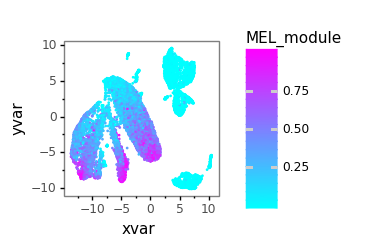

<ggplot: (8772792371369)>
bKRT_module


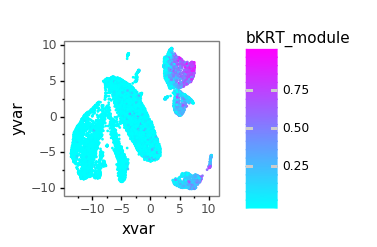

<ggplot: (-9223363264062490168)>
sbKRT_module


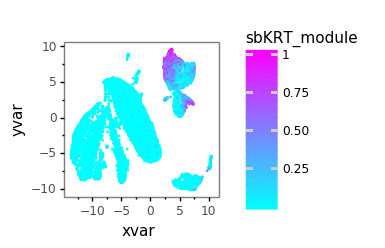

<ggplot: (-9223363264062573077)>
dendritic_module


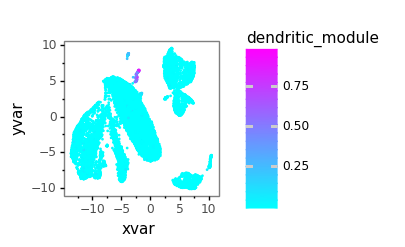

<ggplot: (8772792287969)>
mast_module


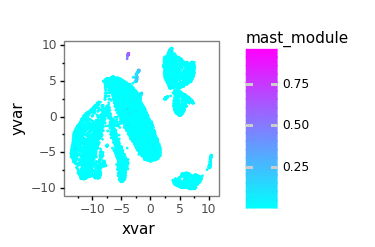

<ggplot: (-9223363264057845188)>
eccrine_module


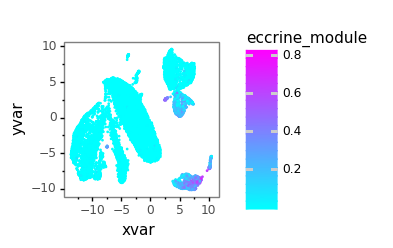

<ggplot: (8772799878008)>
msc_module


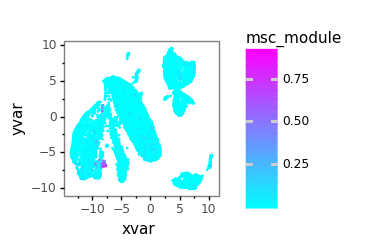

<ggplot: (8772800009101)>
tcell_module


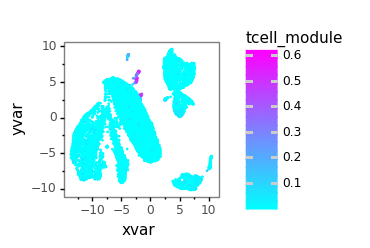

<ggplot: (8772799673408)>


In [15]:
input_adata = full_adata
    
MEL_module = ['TYR','TYRP1','DCT','MITF','IGFBP7','PMEL','MLANA']
bKRT_module = ['ITGB4','KRT14','KRT5']
sbKRT_module = ['KRT1','DSG1','DSC3']
ecc_module = ['KRT18','KRT19','KRT8','CFTR', 'AQP5','S100P']
dendritic_module = ['FCGR2A','FCER1G','C1QC','LAPTM5','CSF1R','AIF1']
mast_module = ['LAPTM5','FCER1G','SLC18A2','GATA2',
               'TPSAB1','CPA3','HDC','GATA2']
msc_module = ['EDNRA','PRRX1','CDH11','COL6A2','TWIST1','TWIST2']
tcell_module = ['TYROBP','CSF1R','LAPTM5','FCGR2A','FCER1G','LCP1','CD4','C1QC',
                'FYB','CORO1A','CXCR4','CD3D','CD52','PTPRCAP','IL32']

# compile modules
modules_dict = {
                'MEL_module':MEL_module,
                'bKRT_module':bKRT_module,
                'sbKRT_module':sbKRT_module,
                'dendritic_module':dendritic_module,
                'mast_module':mast_module,
                'eccrine_module':ecc_module,
                'msc_module':msc_module, 
                'tcell_module':tcell_module
               }

input_adata.obs['cell'] = input_adata.obs.index.tolist()
input_adata.obs['cell'] = (input_adata
                          .obs['cell']
                          .astype(str)
                          .astype(CategoricalDtype(input_adata.obs['cell'].tolist())))
cat, exp_df = prepare_dataframe(input_adata,
                 var_names = input_adata.var_names,
                 groupby = 'cell')
exp_df = exp_df.rank(pct=True, method = 'dense')

for key,value in modules_dict.items():
    print(key)
    input_adata.obs[key] = exp_df.loc[:,value].mean(axis=1)
#         sc.pl.umap(input_adata, color=[key], cmap = 'magma', palette = 'tab20')

    umap_df = pd.DataFrame(input_adata.obsm['X_umap'], columns = ['xvar','yvar'])
    umap_df[key] = input_adata.obs[key].values

    plotnine.options.figure_size = (2,2)
    plot = (ggplot(umap_df)
            + theme_bw()
            + theme(aspect_ratio = 1,
                    panel_grid_major = element_blank(), 
                    panel_grid_minor = element_blank()
                   )
            + geom_point(aes('xvar','yvar',color=key), size = 0.1)
            + scale_color_cmap('cool')
           )
    print(plot)


## FACs gate x cell type

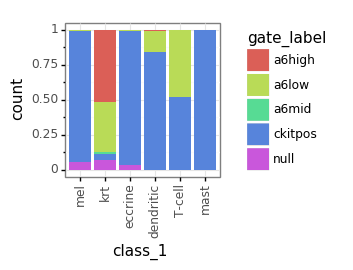

<ggplot: (-9223363264100081881)>

In [16]:
plot_df = (full_adata
             .obs
             .loc[:,['class_1', 'gate_label']]
                       )
plot_df['class_1'] = [x[4:] if x.startswith('cyc_') else x for x in plot_df['class_1']]
label_order = list(plot_df['class_1'].value_counts().index)

plot_df = pd.DataFrame(plot_df
             .groupby('class_1')['gate_label']
             .value_counts()
            ).rename(columns = {'gate_label':'count'})
plot_df = (plot_df / plot_df.groupby('class_1').sum()).reset_index()
plot_df['class_1'] = (plot_df['class_1']
                      .astype(str)
                      .astype(CategoricalDtype(label_order, ordered = True))
                     )

plot = (ggplot(plot_df)
        + theme_bw()
        + theme(axis_text_x = element_text(angle=90))
        + geom_bar(aes('class_1','count',fill='gate_label'), stat='identity')
       )
plot